In [1]:
from nilearn.maskers import NiftiMasker
from scipy import stats
from scipy.io import loadmat
from scipy.stats import ttest_1samp
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nibabel as nib
import pandas as pd
import os, glob

In [10]:
#load matrix
def load_matrix():
    data = loadmat('/Volumes/Cingulate/Sweetspot_Seg/binary_subject_matrix.mat')
    first_matrix = data['first_matrix']
    masker = NiftiMasker(mask_img='/Volumes/Cingulate/Sweetspot_Seg/Outputs/binary/zones1-2/binary_n-map.nii.gz', standardize=True)
    mask_nii = masker.fit()
    return mask_nii, first_matrix

#index matrix and df by cohort
def matrix_df_selection(first_matrix,df_array):
    ranges = [(0, 3), (4, 5), (6, 18), (19, 21), (22, 25), (26, 27), (28, 29), (30, 32), (32, 33), (34, 37), (38, 39), (40, 47)]
    second_matrix,df_selection = first_matrix.copy(),df_array.copy()
    
    #make cohort matricies
    cingulotomy_rows = np.concatenate([np.arange(start, end) for start, end in ranges])
    cingulotomy_matrix = second_matrix[cingulotomy_rows]
    cap_sct_matrix = np.delete(second_matrix,cingulotomy_rows,axis=0)
    
    #make clinical outcomes cohorts
    cingulotomy_df = df_selection[cingulotomy_rows]
    cap_sct_df = np.delete(df_selection,cingulotomy_rows, axis=0)
    
    return cingulotomy_matrix, cap_sct_matrix, cingulotomy_df, cap_sct_df

df = pd.read_csv('/Volumes/Cingulate/Sweetspot_Seg/All_YBOCS_Vol_Cohort.csv')
df_array = df['Relative'].to_numpy().reshape(-1, 1) #change for absolute vs relative

mask_nii, first_matrix = load_matrix()
cingulotomy_matrix, cap_sct_matrix, cingulotomy_df, cap_sct_df = matrix_df_selection(first_matrix,df_array)

In [14]:
#n-map
n_matrix = cingulotomy_matrix.copy() #change for cohort
n_matrix[np.isnan(n_matrix)] = 0 #make nans 0

sum_vector = np.sum(n_matrix,axis=0)
sum_vector_reshape = sum_vector.reshape(1,-1)

#mean image
mean_matrix = cingulotomy_matrix.copy() #make 0s NaNs
mean_matrix[mean_matrix == 0] = np.nan

# repeat the rows to create a final array (x, 451938)
df_matrix = np.tile(cingulotomy_df, (1, 451938)) #change for cohort
co_matrix = np.multiply(mean_matrix, df_matrix) #multiply so each row has clinical outcomes

#sum each row up to get a vector and make a mean-image
co_sum_vector = np.nansum(co_matrix,axis=0)
co_sum_vector_reshape = co_sum_vector.reshape(1,-1)

In [18]:
#make t-map and p-map
def t_test(matrix, df):
    def one_sample_t_test(col, null):
        no_nan_col = col[~np.isnan(col)]
        if len(no_nan_col) > 1:
            t_stat, p_value = ttest_1samp(no_nan_col, null)
            return t_stat, p_value
        else: #if there's not enough values left over, returns nan
            return np.nan, np.nan
    null = cingulotomy_df.mean() #change for population mean: df['Relative'].mean() or 0
    result = np.apply_along_axis(one_sample_t_test, axis=0, arr=co_matrix, null=null) #creates 2d array, first row is t, second is p

    t_statistics = result[0]
    p_values = result[1]
    
    #threshold for significant positive
    sig_t,sig_p = t_statistics.copy(), p_values.copy()
    sig_mask = (p_values > 0) & (p_values <= 0.05)
    sig_t[sig_mask == 0], sig_p[sig_mask == 0] = 0,0
    pos_sig_t,pos_sig_p = sig_t.copy(),sig_p.copy()
    pos_sig_t[sig_t < 0],pos_sig_p[sig_p < 0] = 0,0

    #threshold n-map
    threshold = 5
    thresholded_vector = np.array(sum_vector)
    thresholded_pos_sig_t = pos_sig_t.copy()
    thresholded_vector[thresholded_vector <= threshold] = 0

    binary_threshold_n_vector = thresholded_vector.copy()        
    binary_threshold_n_vector[binary_threshold_n_vector > 0] = 1
    thresholded_pos_sig_t[binary_threshold_n_vector == 0] = 0
    
#     t_reshape = thresholded_pos_sig_t.reshape(1,-1)
#     t_map = mask_nii.inverse_transform(t_reshape[0])
#     t_map.to_filename('/Volumes/Cingulate/Sweetspot_Seg/Outputs/matrix_tests/cing_sig_pos_thresholded_avg_t-map.nii.gz')

    return thresholded_pos_sig_t

def overlap(thresholded_pos_sig_t):
    df_column = cingulotomy_df.flatten() #change for cohort
    matrix = cingulotomy_matrix #change for cohort
    score = np.zeros((matrix.shape[0]))

    for i in range(matrix.shape[0]):
        score[i] = np.mean(np.multiply(thresholded_pos_sig_t[matrix[i, :] != 0], matrix[i, matrix[i, :] != 0]))

    r, p = pearsonr(score, df_column)
    return score, r, p

def cross_validations(matrix, df):
    num_sub = matrix.shape[0]
    for i in range(num_sub):
        print(f'Iteration: {i + 1}/{num_sub}')
        current_subject_matrix = np.delete(matrix, i, axis=0) #exclude the i-th subject
        current_clinical_outcomes = np.delete(df, i, axis=0) #exclude i-th subject's clinical outcomes
        thresholded_pos_sig_t = t_test(current_subject_matrix,current_clinical_outcomes)
        score, r, p = overlap(thresholded_pos_sig_t)
    return score, r, p
        
matrix = cingulotomy_matrix #change for cohort
df = cingulotomy_df #change for cohort

thresholded_pos_sig_t = t_test(matrix,df)
score, r, p = overlap(thresholded_pos_sig_t)
score, r, p = cross_validations(matrix,df)

Iteration: 1/37
Iteration: 2/37
Iteration: 3/37
Iteration: 4/37
Iteration: 5/37
Iteration: 6/37
Iteration: 7/37
Iteration: 8/37
Iteration: 9/37
Iteration: 10/37
Iteration: 11/37
Iteration: 12/37
Iteration: 13/37
Iteration: 14/37
Iteration: 15/37
Iteration: 16/37
Iteration: 17/37
Iteration: 18/37
Iteration: 19/37
Iteration: 20/37
Iteration: 21/37
Iteration: 22/37
Iteration: 23/37
Iteration: 24/37
Iteration: 25/37
Iteration: 26/37
Iteration: 27/37
Iteration: 28/37
Iteration: 29/37
Iteration: 30/37
Iteration: 31/37
Iteration: 32/37
Iteration: 33/37
Iteration: 34/37
Iteration: 35/37
Iteration: 36/37
Iteration: 37/37


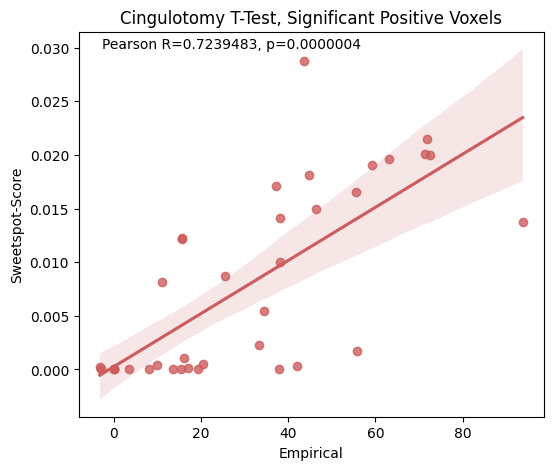

In [19]:
#cingulotomies, relative
def plot_analysis(x_data, y_data, title, r,p, color):
    plt.figure(figsize=(6, 5))
    ax = sns.regplot(x=x_data, y=y_data, color=color)
    plt.title(title)
    plt.xlabel('Empirical')
    plt.ylabel('Sweetspot-Score')
    ax.text(0.05, 0.95, 'Pearson R={:.7f}, p={:.7f}'.format(r, p),
            transform=ax.transAxes, verticalalignment='bottom')
    plt.show()

#pearson analysis
plot_analysis(cingulotomy_df, score, 'Cingulotomy T-Test, Significant Positive Voxels', r,p, 'indianred')

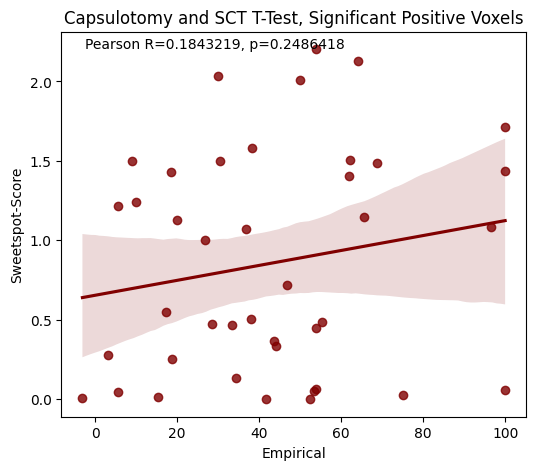

In [13]:
#capsulotomies & sct, relative
def plot_analysis(x_data, y_data, title, r,p, color):
    plt.figure(figsize=(6, 5))
    ax = sns.regplot(x=x_data, y=y_data, color=color)
    plt.title(title)
    plt.xlabel('Empirical')
    plt.ylabel('Sweetspot-Score')
    ax.text(0.05, 0.95, 'Pearson R={:.7f}, p={:.7f}'.format(r, p),
            transform=ax.transAxes, verticalalignment='bottom')
    plt.show()

#pearson analysis
plot_analysis(cap_sct_df, score, 'Capsulotomy and SCT T-Test, Significant Positive Voxels', r,p, 'maroon')